# Ensemble Learning with Traditional ML Models (Using K-Fold Cross Validation)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import f1_score
import optuna
import os

/var/folders/rt/yf3df5s52_589vft9vpfml9c0000gn/T/ipykernel_10726/3887039854.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_DIR = "data/Regular_processed/Without_Ordinal_Encoding/"
X_train = np.load(os.path.join(DATA_DIR, "X_train.npy"))
X_valid = np.load(os.path.join(DATA_DIR, "X_valid.npy"))
y_train = np.load(os.path.join(DATA_DIR, "y_train.npy"))
y_valid = np.load(os.path.join(DATA_DIR, "y_valid.npy"))
X_test = np.load(os.path.join(DATA_DIR, "X_test.npy"))

for arr in [X_train, X_valid, y_train, y_valid, X_test]:
    print(arr.shape)

(988, 66)
(247, 66)
(988,)
(247,)
(824, 66)


# Performing K-Fold Splitting

In [8]:
X_total = np.concatenate((X_train, X_valid), axis=0)
y_total = np.concatenate((y_train, y_valid), axis=0)
print(f"X_total: {X_total.shape}\ny_total: {y_total.shape}")

X_total: (1235, 66)
y_total: (1235,)


In [83]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=42069, shuffle=True)

X_train_list = []
X_valid_list = []
y_train_list = []
y_valid_list = []
train_idx_list = []
valid_idx_list = []

for train_idx, valid_idx in kf.split(X_total):
    X_train_fold, X_valid_fold = X_total[train_idx], X_total[valid_idx]
    y_train_fold, y_valid_fold = y_total[train_idx], y_total[valid_idx]

    X_train_list.append(X_train_fold)
    X_valid_list.append(X_valid_fold)
    y_train_list.append(y_train_fold)
    y_valid_list.append(y_valid_fold)

    train_idx_list.append(train_idx)
    valid_idx_list.append(valid_idx)

print(f"Shape of each fold\nX_train_fold = {X_train_list[0].shape}\nX_valid_fold = {X_valid_list[0].shape}\ny_train_list = {y_train_list[0].shape}\ny_valid_list = {y_valid_list[0].shape}")

Shape of each fold
X_train_fold = (988, 66)
X_valid_fold = (247, 66)
y_train_list = (988,)
y_valid_list = (247,)


In [82]:
list(kf.split(X_total))

[(array([   0,    1,    2,    3,    4,    6,    7,    8,    9,   10,   11,
           12,   13,   14,   15,   16,   17,   19,   20,   21,   22,   23,
           24,   25,   26,   27,   29,   30,   31,   33,   34,   36,   37,
           39,   40,   42,   43,   45,   46,   47,   48,   49,   50,   51,
           52,   53,   54,   55,   56,   57,   58,   60,   61,   62,   63,
           64,   65,   66,   67,   68,   69,   71,   72,   74,   75,   76,
           77,   78,   80,   81,   82,   83,   84,   85,   87,   88,   89,
           90,   91,   92,   93,   94,   96,   97,   98,   99,  100,  101,
          102,  103,  104,  106,  107,  108,  109,  111,  113,  114,  115,
          116,  117,  119,  120,  122,  123,  124,  125,  126,  127,  131,
          132,  134,  135,  136,  137,  138,  139,  141,  142,  143,  144,
          146,  147,  148,  149,  151,  152,  153,  154,  155,  156,  157,
          159,  160,  162,  163,  164,  165,  166,  167,  168,  170,  171,
          172,  174,  175

# Loading Traditional ML Models

### Random Forest

In [16]:
average = lambda a_list: sum(a_list) / len(a_list)
argmax = lambda a_list: a_list.index(max(a_list))

In [18]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_list[fold_no]
    X_valid_fold = X_valid_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]

    random_forest_classifier = RandomForestClassifier(max_depth=3, random_state=123, criterion='entropy', n_estimators=12)
    random_forest_classifier.fit(X_train_fold, y_train_fold)
    random_forest_classifiers_list.append(random_forest_classifier)
    train_preds = random_forest_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = random_forest_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)

print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")

Train F1 Scores: [0.6771255060728745, 0.6852226720647774, 0.6700404858299596, 0.6761133603238867, 0.6892712550607287]; Avg = 0.6795546558704454
Valid F1 Scores: [0.6477732793522267, 0.6518218623481782, 0.6639676113360324, 0.680161943319838, 0.6761133603238867]; Avg = 0.6639676113360324
Best Fold = 3


In [19]:
def objective(trial):
    # Suggest values for the hyperparameters using a trial object.
    rf_criterion = trial.suggest_categorical('rf_criterion', ['gini', 'entropy', 'log_loss'])
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 7, log=True)
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 2, 50, log=True)
    
    train_f1_list = []
    valid_f1_list = []
    for fold_no in range(len(X_train_list)):
        X_train_fold = X_train_list[fold_no]
        X_valid_fold = X_valid_list[fold_no]
        y_train_fold = y_train_list[fold_no]
        y_valid_fold = y_valid_list[fold_no]

        random_forest_classifier = RandomForestClassifier(max_depth=rf_max_depth, random_state=123, criterion=rf_criterion, n_estimators=rf_n_estimators)
        random_forest_classifier.fit(X_train_fold, y_train_fold)
        train_preds = random_forest_classifier.predict(X_train_fold)
        train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
        train_f1_list.append(train_f1_score)
        valid_preds = random_forest_classifier.predict(X_valid_fold)
        valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
        valid_f1_list.append(valid_f1_score)
    
    return average(valid_f1_list)  # - abs((train_f1_score - valid_f1_score)/7)

# Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-04-19 22:24:31,424] A new study created in memory with name: no-name-c397f2da-d2c3-4909-998c-3519039c1daa
[I 2024-04-19 22:24:31,455] Trial 0 finished with value: 0.6259109311740889 and parameters: {'rf_criterion': 'gini', 'rf_max_depth': 3, 'rf_n_estimators': 2}. Best is trial 0 with value: 0.6259109311740889.
[I 2024-04-19 22:24:31,476] Trial 1 finished with value: 0.6299595141700405 and parameters: {'rf_criterion': 'entropy', 'rf_max_depth': 5, 'rf_n_estimators': 2}. Best is trial 1 with value: 0.6299595141700405.
[I 2024-04-19 22:24:31,543] Trial 2 finished with value: 0.6364372469635627 and parameters: {'rf_criterion': 'gini', 'rf_max_depth': 2, 'rf_n_estimators': 20}. Best is trial 2 with value: 0.6364372469635627.
[I 2024-04-19 22:24:31,624] Trial 3 finished with value: 0.6736842105263158 and parameters: {'rf_criterion': 'log_loss', 'rf_max_depth': 4, 'rf_n_estimators': 21}. Best is trial 3 with value: 0.6736842105263158.
[I 2024-04-19 22:24:31,786] Trial 4 finished with

In [21]:
print(f"Best Trial\nValid Foldwise Averaged Micro Averaged F1 Score: {study.best_trial.values}\nHyperParameters = {study.best_trial.params}")

Best Trial
Valid Foldwise Averaged Micro Averaged F1 Score: [0.6947368421052632]
HyperParameters = {'rf_criterion': 'gini', 'rf_max_depth': 7, 'rf_n_estimators': 43}


In [23]:
random_forest_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_list[fold_no]
    X_valid_fold = X_valid_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]

    random_forest_classifier = RandomForestClassifier(max_depth=7, random_state=123, criterion='gini', n_estimators=43)
    random_forest_classifier.fit(X_train_fold, y_train_fold)
    random_forest_classifiers_list.append(random_forest_classifier)
    train_preds = random_forest_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = random_forest_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)

print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")

Train F1 Scores: [0.832995951417004, 0.8421052631578947, 0.8228744939271255, 0.8340080971659919, 0.8289473684210527]; Avg = 0.8321862348178138
Valid F1 Scores: [0.6680161943319838, 0.659919028340081, 0.7489878542510121, 0.7004048582995951, 0.6963562753036437]; Avg = 0.6947368421052632
Best Fold = 2


### Bernoulli Naive Bayes

In [26]:
from sklearn.naive_bayes import BernoulliNB

naive_bayes_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_list[fold_no]
    X_valid_fold = X_valid_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]

    naive_bayes_classifier = BernoulliNB()
    naive_bayes_classifier.fit(X_train_fold, y_train_fold)
    naive_bayes_classifiers_list.append(naive_bayes_classifier)
    train_preds = naive_bayes_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = naive_bayes_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)

print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")

Train F1 Scores: [0.6923076923076923, 0.6963562753036437, 0.687246963562753, 0.6933198380566802, 0.6862348178137652]; Avg = 0.691093117408907
Valid F1 Scores: [0.6842105263157895, 0.659919028340081, 0.7044534412955465, 0.659919028340081, 0.7004048582995951]; Avg = 0.6817813765182186
Best Fold = 2


### Nearest Centroid

In [33]:
from sklearn.neighbors import NearestCentroid

nearest_centroid_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_list[fold_no]
    X_valid_fold = X_valid_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]

    nearest_centroid_classifier = NearestCentroid(metric='braycurtis')
    nearest_centroid_classifier.fit(X_train_fold, y_train_fold)
    nearest_centroid_classifiers_list.append(nearest_centroid_classifier)
    train_preds = nearest_centroid_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = nearest_centroid_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)

print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")

Train F1 Scores: [0.6639676113360324, 0.6680161943319838, 0.6487854251012146, 0.6518218623481782, 0.6548582995951417]; Avg = 0.6574898785425102
Valid F1 Scores: [0.6396761133603239, 0.6072874493927125, 0.6842105263157895, 0.6639676113360324, 0.6518218623481782]; Avg = 0.6493927125506074
Best Fold = 2


/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:201: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_cent

In [29]:
def objective(trial):
    # Suggest values for the hyperparameters using a trial object.
    rf_metric = trial.suggest_categorical('rf_metric', ['hamming', 'cosine', 'euclidean', 'yule', 'russellrao', 'jaccard', 'chebyshev',
                                                        'sokalmichener', 'sqeuclidean', 'matching', 'rogerstanimoto', 'nan_euclidean',
                                                        'dice', 'sokalsneath', 'correlation', 'canberra', 'manhattan', 'braycurtis'])
    train_f1_list = []
    valid_f1_list = []
    for fold_no in range(len(X_train_list)):
        X_train_fold = X_train_list[fold_no]
        X_valid_fold = X_valid_list[fold_no]
        y_train_fold = y_train_list[fold_no]
        y_valid_fold = y_valid_list[fold_no]

        nearest_centroid_classifier = NearestCentroid(metric='correlation')
        nearest_centroid_classifier.fit(X_train_fold, y_train_fold)
        train_preds = nearest_centroid_classifier.predict(X_train_fold)
        train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
        train_f1_list.append(train_f1_score)
        valid_preds = nearest_centroid_classifier.predict(X_valid_fold)
        valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
        valid_f1_list.append(valid_f1_score)
    
    return average(valid_f1_list)

# Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-04-19 22:45:07,299] A new study created in memory with name: no-name-a7877b2a-c246-41be-b8ae-583816aecc11
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:201: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/U

In [31]:
print(f"Best Trial\nFoldwise Averaged Valid Micro Averaged F1 Score: {study.best_trial.values}\nHyperParameters = {study.best_trial.params}")

Best Trial
Foldwise Averaged Valid Micro Averaged F1 Score: [0.6607287449392711]
HyperParameters = {'rf_metric': 'braycurtis'}


## XGBoost

In [36]:
import xgboost as xgb
from sklearn.metrics import f1_score

xgboost_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_list[fold_no]
    X_valid_fold = X_valid_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]

    xgboost_classifier = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, objective='multi:softmax', num_class=3, random_state=123)
    xgboost_classifier.fit(X_train_fold, y_train_fold)
    xgboost_classifiers_list.append(xgboost_classifier)
    train_preds = xgboost_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = xgboost_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)

print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")

Train F1 Scores: [0.9939271255060729, 0.9979757085020243, 0.9969635627530364, 0.9979757085020243, 0.9949392712550608]; Avg = 0.9963562753036438
Valid F1 Scores: [0.6923076923076923, 0.6923076923076923, 0.7206477732793523, 0.728744939271255, 0.7125506072874493]; Avg = 0.7093117408906882
Best Fold = 3


In [38]:
import xgboost as xgb
from sklearn.model_selection import KFold
import optuna

def objective(trial):
    # Define XGBoost parameters to be optimized
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1, 20),
        'max_depth': trial.suggest_int('max_depth', 1, 7),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.5)
    }

    train_f1_list = []
    valid_f1_list = []
    for fold_no in range(len(X_train_list)):
        X_train_fold = X_train_list[fold_no]
        X_valid_fold = X_valid_list[fold_no]
        y_train_fold = y_train_list[fold_no]
        y_valid_fold = y_valid_list[fold_no]

        xgboost_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=123, **params)
        xgboost_classifier.fit(X_train_fold, y_train_fold)
        xgboost_classifiers_list.append(xgboost_classifier)
        train_preds = xgboost_classifier.predict(X_train_fold)
        train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
        train_f1_list.append(train_f1_score)
        valid_preds = xgboost_classifier.predict(X_valid_fold)
        valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
        valid_f1_list.append(valid_f1_score)
    
    # Compute the average F1 score across all folds
    avg_f1_score = average(valid_f1_list)
    
    return avg_f1_score

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best trial
best_trial = study.best_trial
print(f'Best Trial - F1 Score: {best_trial.value:.4f}')
print(f'Best Hyperparameters: {best_trial.params}')

[I 2024-04-19 23:29:28,000] A new study created in memory with name: no-name-620c5998-952a-462f-afaa-ff0e8f64d1c0
/var/folders/rt/yf3df5s52_589vft9vpfml9c0000gn/T/ipykernel_10726/3697127513.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.5)
[I 2024-04-19 23:29:28,186] Trial 0 finished with value: 0.6429149797570851 and parameters: {'n_estimators': 9, 'max_depth': 7, 'learning_rate': 0.035205687460722494}. Best is trial 0 with value: 0.6429149797570851.
/var/folders/rt/yf3df5s52_589vft9vpfml9c0000gn/T/ipykernel_10726/3697127513.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': tr

Best Trial - F1 Score: 0.7028
Best Hyperparameters: {'n_estimators': 14, 'max_depth': 5, 'learning_rate': 0.49642251394606685}


In [40]:
xgboost_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_list[fold_no]
    X_valid_fold = X_valid_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]

    xgboost_classifier = xgb.XGBClassifier(n_estimators=14, max_depth=5, learning_rate=0.4964, objective='multi:softmax', num_class=3, random_state=123)
    xgboost_classifier.fit(X_train_fold, y_train_fold)
    xgboost_classifiers_list.append(xgboost_classifier)
    train_preds = xgboost_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = xgboost_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)

print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")


Train F1 Scores: [0.9524291497975709, 0.9544534412955465, 0.9574898785425101, 0.958502024291498, 0.9544534412955465]; Avg = 0.9554655870445344
Valid F1 Scores: [0.6963562753036437, 0.6761133603238867, 0.728744939271255, 0.6963562753036437, 0.7165991902834008]; Avg = 0.702834008097166
Best Fold = 2


## LightGBM

In [71]:
import lightgbm as lgb
from sklearn.metrics import f1_score

lgb_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_list[fold_no]
    X_valid_fold = X_valid_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]

    # Create LightGBM classifier instance
    lgb_classifier = lgb.LGBMClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        objective='multiclass',  # Use 'multiclass' for multi-class classification
        num_class=3,
        random_state=123,
        verbosity=-1
    )  # verbosity=-1 is to suppress the constant printing
    lgb_classifier.fit(X_train_fold, y_train_fold)
    lgb_classifiers_list.append(lgb_classifier)
    train_preds = lgb_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = lgb_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)

print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")

Train F1 Scores: [0.9969635627530364, 0.9989878542510121, 0.9959514170040485, 0.9989878542510121, 0.9969635627530364]; Avg = 0.9975708502024292
Valid F1 Scores: [0.708502024291498, 0.7004048582995951, 0.7246963562753036, 0.7449392712550608, 0.7368421052631579]; Avg = 0.7230769230769231
Best Fold = 3


In [72]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import optuna

def objective(trial):
    # Define LightGBM parameters to be optimized
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1, 20),
        'max_depth': trial.suggest_int('max_depth', 1, 7),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.5)
    }
    
    lgb_classifiers_list = []
    train_f1_list = []
    valid_f1_list = []
    for fold_no in range(len(X_train_list)):
        X_train_fold = X_train_list[fold_no]
        X_valid_fold = X_valid_list[fold_no]
        y_train_fold = y_train_list[fold_no]
        y_valid_fold = y_valid_list[fold_no]

        # Create LightGBM classifier instance
        lgb_classifier = lgb.LGBMClassifier(objective='multiclass', num_class=3, random_state=123, verbosity=-1, **params)  # verbosity=-1 is to suppress the constant printing
        lgb_classifier.fit(X_train_fold, y_train_fold)
        lgb_classifiers_list.append(lgb_classifier)
        train_preds = lgb_classifier.predict(X_train_fold)
        train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
        train_f1_list.append(train_f1_score)
        valid_preds = lgb_classifier.predict(X_valid_fold)
        valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
        valid_f1_list.append(valid_f1_score)

    return average(valid_f1_list)

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best trial
best_trial = study.best_trial
print(f'Best Trial - F1 Score: {best_trial.value:.4f}')
print(f'Best Hyperparameters: {best_trial.params}')

[I 2024-04-20 00:38:04,167] A new study created in memory with name: no-name-6f52da60-eac3-4f65-866a-a1988562238c
/var/folders/rt/yf3df5s52_589vft9vpfml9c0000gn/T/ipykernel_10726/2014977594.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.5)
[I 2024-04-20 00:38:04,569] Trial 0 finished with value: 0.6963562753036436 and parameters: {'n_estimators': 15, 'max_depth': 5, 'learning_rate': 0.10403393837391654}. Best is trial 0 with value: 0.6963562753036436.
/var/folders/rt/yf3df5s52_589vft9vpfml9c0000gn/T/ipykernel_10726/2014977594.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': tr

Best Trial - F1 Score: 0.7085
Best Hyperparameters: {'n_estimators': 20, 'max_depth': 2, 'learning_rate': 0.4418936330913624}


In [73]:
import lightgbm as lgb
from sklearn.metrics import f1_score

lgb_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_list[fold_no]
    X_valid_fold = X_valid_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]

    # Create LightGBM classifier instance
    lgb_classifier = lgb.LGBMClassifier(
        n_estimators=19,
        max_depth=5,
        learning_rate=0.182121,
        objective='multiclass',  # Use 'multiclass' for multi-class classification
        num_class=3,
        random_state=123,
        verbosity=-1   # verbosity=-1 is to suppress the constant printing
    )
    lgb_classifier.fit(X_train_fold, y_train_fold)
    lgb_classifiers_list.append(lgb_classifier)
    train_preds = lgb_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = lgb_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)

print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")


Train F1 Scores: [0.861336032388664, 0.8846153846153846, 0.8765182186234818, 0.8603238866396761, 0.8653846153846154]; Avg = 0.8696356275303643
Valid F1 Scores: [0.680161943319838, 0.7044534412955465, 0.7530364372469636, 0.7165991902834008, 0.7044534412955465]; Avg = 0.7117408906882592
Best Fold = 2


## HistGradientBoostingClassifier

In [49]:
from sklearn.experimental import enable_hist_gradient_boosting  # Enable experimental HistGradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

def objective(trial):
    # Define hyperparameters to be optimized
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.5),
        'max_iter': trial.suggest_int('max_iter', 10, 100, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 7),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-6, 1e-3)
    }
    
    # histgb_classifiers_list = []
    train_f1_list = []
    valid_f1_list = []
    for fold_no in range(len(X_train_list)):
        X_train_fold = X_train_list[fold_no]
        X_valid_fold = X_valid_list[fold_no]
        y_train_fold = y_train_list[fold_no]
        y_valid_fold = y_valid_list[fold_no]

        # Create LightGBM classifier instance
        histgb_classifier = HistGradientBoostingClassifier(**params, random_state=123)
        histgb_classifier.fit(X_train_fold, y_train_fold)
        # histgb_classifiers_list.append(histgb_classifier)
        train_preds = histgb_classifier.predict(X_train_fold)
        train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
        train_f1_list.append(train_f1_score)
        valid_preds = histgb_classifier.predict(X_valid_fold)
        valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
        valid_f1_list.append(valid_f1_score)

    return average(valid_f1_list)

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best trial
best_trial = study.best_trial
print(f'Best Trial - F1 Score: {best_trial.value:.4f}')
print(f'Best Hyperparameters: {best_trial.params}')

[I 2024-04-20 00:01:34,341] A new study created in memory with name: no-name-f8edf9a4-b64d-44bf-8c1a-8092f0c47f69
/var/folders/rt/yf3df5s52_589vft9vpfml9c0000gn/T/ipykernel_10726/3535479977.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.5),
/var/folders/rt/yf3df5s52_589vft9vpfml9c0000gn/T/ipykernel_10726/3535479977.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-6, 1e-3)
[I 2024-04-20 00:01:37,149] Trial 0 finished with value: 0.7101214574898785 and parameters: {'learning_rate': 0.19311852024208462, 'max_iter': 95, 'max_dept

Best Trial - F1 Score: 0.7271
Best Hyperparameters: {'learning_rate': 0.23215781935727378, 'max_iter': 69, 'max_depth': 2, 'min_samples_leaf': 19, 'l2_regularization': 6.605275433883072e-05}


In [52]:
# Best Hyperparameters: {'learning_rate': 0.23215781935727378, 'max_iter': 69, 'max_depth': 2, 'min_samples_leaf': 19, 'l2_regularization': 6.605275433883072e-05}
best_params = {
    'learning_rate': study.best_params['learning_rate'],
    'max_iter': study.best_params['max_iter'],
    'max_depth': study.best_params['max_depth'],
    'min_samples_leaf': study.best_params['min_samples_leaf'],
    'l2_regularization': study.best_params['l2_regularization'],
    'random_state': 123
}

# # Create and train the HistGradientBoostingClassifier with the best hyperparameters
# best_clf = HistGradientBoostingClassifier(**best_params)
# best_clf.fit(X_train, y_train)

histgb_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_list[fold_no]
    X_valid_fold = X_valid_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]

    # Create LightGBM classifier instance
    histgb_classifier = HistGradientBoostingClassifier(**best_params)
    histgb_classifier.fit(X_train_fold, y_train_fold)
    histgb_classifiers_list.append(histgb_classifier)
    train_preds = histgb_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = histgb_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)


print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")


Train F1 Scores: [0.8755060728744939, 0.8836032388663968, 0.8805668016194332, 0.868421052631579, 0.8633603238866396]; Avg = 0.8742914979757085
Valid F1 Scores: [0.7044534412955465, 0.7165991902834008, 0.728744939271255, 0.7611336032388664, 0.7246963562753036]; Avg = 0.7271255060728745
Best Fold = 3


# Ensemble Learning

In [74]:
estimator_dict = {
    'random_forest': random_forest_classifiers_list,
    'nearest_centroid': nearest_centroid_classifiers_list,
    'bernoulli_naive_bayes': naive_bayes_classifiers_list,
    'XGBoost': xgboost_classifiers_list,
    'lgbm': lgb_classifiers_list,
    'histgb': histgb_classifiers_list
}
estimators = list(estimator_dict.items())

### Analysis of Models

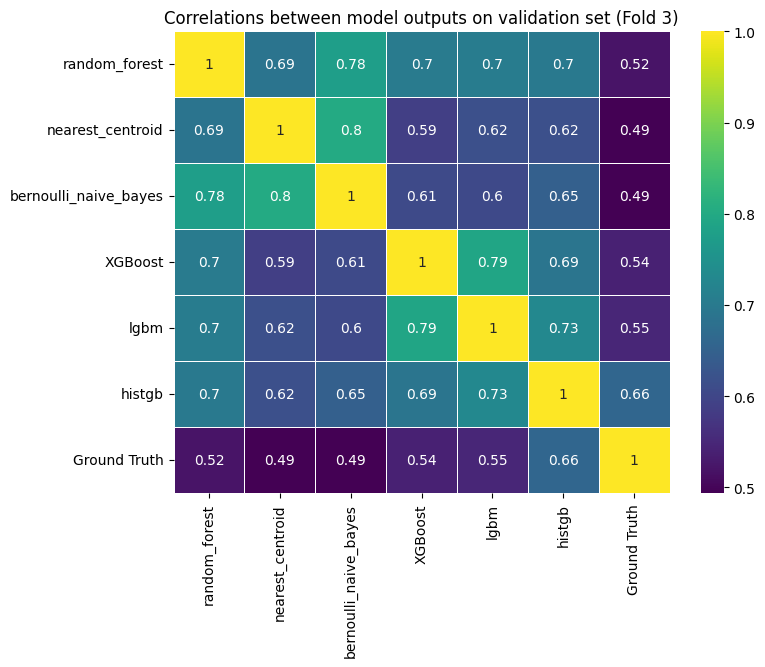

In [75]:
FOLD_NO = 3

val_preds_df = pd.DataFrame()
for name, model in estimators:
    val_preds_df[name] = model[FOLD_NO].predict(X_valid_list[FOLD_NO])
val_preds_df['Ground Truth'] = y_valid_list[FOLD_NO]

# Create the heatmap
plt.figure(figsize = (8,6))
sns.heatmap(val_preds_df.corr(), cmap = 'viridis', annot=True, linewidths=.5)
plt.title(f"Correlations between model outputs on validation set (Fold {FOLD_NO})")
plt.show()

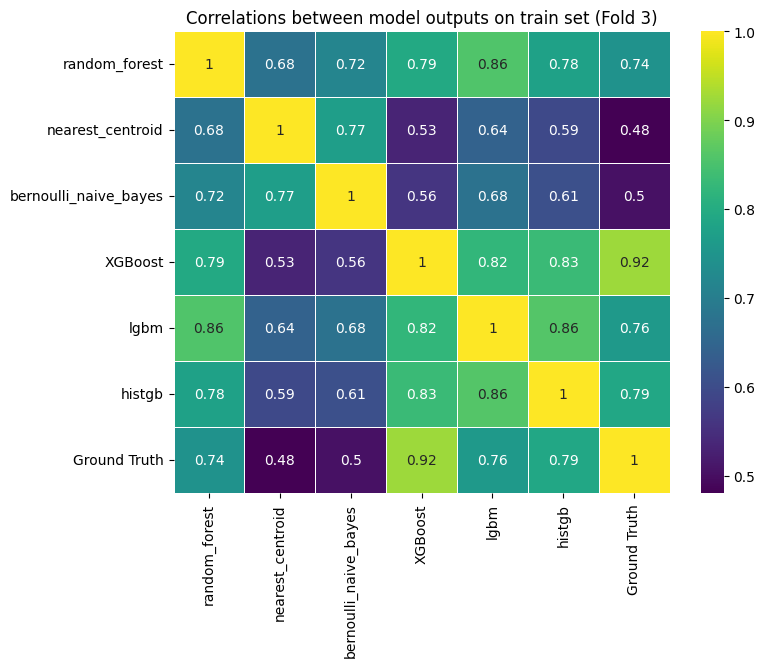

In [76]:
FOLD_NO = 3
train_preds_df = pd.DataFrame()
for name, model in estimators:
    train_preds_df[name] = model[FOLD_NO].predict(X_train_list[FOLD_NO])
train_preds_df['Ground Truth'] = y_train_list[FOLD_NO]

# Create the heatmap
plt.figure(figsize = (8,6))
sns.heatmap(train_preds_df.corr(), cmap = 'viridis', annot=True, linewidths=.5)
plt.title(f"Correlations between model outputs on train set (Fold {FOLD_NO})")
plt.show()

### Voting Classifier

In [77]:
from sklearn.ensemble import VotingClassifier

voting_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_list[fold_no]
    X_valid_fold = X_valid_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]
    fold_wise_estimators = [(k, v[fold_no]) for k, v in estimators]

    voting_classifier = VotingClassifier(estimators=fold_wise_estimators, voting='hard', weights=[3, 2, 1, 1, 1, 1])
    voting_classifier.fit(X_train_fold, y_train_fold)
    voting_classifiers_list.append(voting_classifier)
    train_preds = voting_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = voting_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)

print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")


/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:201: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_cent

Train F1 Scores: [0.832995951417004, 0.8461538461538461, 0.8289473684210527, 0.8309716599190283, 0.8259109311740891]; Avg = 0.832995951417004
Valid F1 Scores: [0.6761133603238867, 0.6720647773279352, 0.7651821862348178, 0.7206477732793523, 0.708502024291498]; Avg = 0.7085020242914979
Best Fold = 2


#### Optimising Voting Classifier Weights 

In [78]:
def objective(trial):
    # Define the range for each weight to optimize
    weights = [trial.suggest_float(f'weight_{i}', 0.1, 10.0) for i in range(len(estimators))]

    train_f1_list = []
    valid_f1_list = []
    for fold_no in range(len(X_train_list)):
        X_train_fold = X_train_list[fold_no]
        X_valid_fold = X_valid_list[fold_no]
        y_train_fold = y_train_list[fold_no]
        y_valid_fold = y_valid_list[fold_no]
        fold_wise_estimators = [(k, v[fold_no]) for k, v in estimators]

        voting_classifier = VotingClassifier(estimators=fold_wise_estimators, voting='hard', weights=weights)
        voting_classifier.fit(X_train_fold, y_train_fold)
        # voting_classifiers_list.append(voting_classifier)
        train_preds = voting_classifier.predict(X_train_fold)
        train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
        train_f1_list.append(train_f1_score)
        valid_preds = voting_classifier.predict(X_valid_fold)
        valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
        valid_f1_list.append(valid_f1_score)
    
    return average(valid_f1_list)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # You can adjust the number of trials

# Get the best weights found by Optuna
best_weights = study.best_params
print("Best Weights:", best_weights)

best_weights = [best_weights[f'weight_{i}'] for i in range(len(estimators))]

voting_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_list[fold_no]
    X_valid_fold = X_valid_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]
    fold_wise_estimators = [(k, v[fold_no]) for k, v in estimators]

    voting_classifier = VotingClassifier(estimators=fold_wise_estimators, voting='hard', weights=best_weights)
    voting_classifier.fit(X_train_fold, y_train_fold)
    voting_classifiers_list.append(voting_classifier)
    train_preds = voting_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = voting_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)

print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")


[I 2024-04-20 00:39:52,685] A new study created in memory with name: no-name-7ab1f7d5-34e6-4e0d-9fee-509c1fd354ae
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:201: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/U

Best Weights: {'weight_0': 1.5201587176332896, 'weight_1': 9.141253654579875, 'weight_2': 4.39040135925183, 'weight_3': 3.76469173282105, 'weight_4': 6.284197260519576, 'weight_5': 7.168591544502608}


/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:201: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_cent

Train F1 Scores: [0.8552631578947368, 0.8704453441295547, 0.8663967611336032, 0.8512145748987854, 0.8572874493927125]; Avg = 0.8601214574898786
Valid F1 Scores: [0.7125506072874493, 0.6882591093117408, 0.7813765182186235, 0.7489878542510121, 0.7165991902834008]; Avg = 0.7295546558704453
Best Fold = 2


In [79]:
# Generate Voting Classifier CSV
BEST_FOLD = 2
test_preds = voting_classifiers_list[BEST_FOLD].predict(X_test)

PRED_CATEGORIES = ['died', 'euthanized', 'lived']
pred_list = [PRED_CATEGORIES[el] for el in test_preds]

submission_df = pd.DataFrame()
df_test_raw = pd.read_csv("data/test.csv")
submission_df['id'] = df_test_raw['id']
submission_df['outcome'] = pred_list

submission_df.to_csv("submissions/Without_Ordinal_Encoding/K_Fold_Cross_Val/VotingClassifier_Ensemble_6_RandomForest_7_43_NearestCentroid_NaiveBayes_XGBoost_LGBM_HistGB_Submission.csv", index=False)

### Stacking Classifier

In [80]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier

stacking_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_list[fold_no]
    X_valid_fold = X_valid_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]
    fold_wise_estimators = [(k, v[fold_no]) for k, v in estimators]

    stacking_classifier = StackingClassifier(estimators=fold_wise_estimators, final_estimator=DecisionTreeClassifier())
    stacking_classifier.fit(X_train_fold, y_train_fold)
    stacking_classifiers_list.append(stacking_classifier)
    train_preds = stacking_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = stacking_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)

print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")


/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:201: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_centroid.py:150: FutureWarning: Support for distance metrics other than euclidean and manhattan and for callables was deprecated in version 1.3 and will be removed in version 1.5.
  warnings.warn(
/Users/harshraod/miniconda3/envs/MachineLearningProject/lib/python3.10/site-packages/sklearn/neighbors/_nearest_cent

Train F1 Scores: [0.6862348178137652, 0.7145748987854251, 0.6852226720647774, 0.7095141700404858, 0.6558704453441295]; Avg = 0.6902834008097166
Valid F1 Scores: [0.562753036437247, 0.6072874493927125, 0.5910931174089069, 0.680161943319838, 0.5991902834008097]; Avg = 0.6080971659919028
Best Fold = 3


### Custom Ensemble using Decision Tree & Some inputs columns

In [97]:
train_preds_dfs_list = []
val_preds_dfs_list = []
test_preds_dfs_list = []
for fold_no in range(len(X_train_list)):
    train_preds_df = pd.DataFrame()
    for name, model in estimator_dict.items():
        train_preds_df[name] = model[fold_no].predict(X_train_list[fold_no])

    val_preds_df = pd.DataFrame()
    for name, model in estimator_dict.items():
        val_preds_df[name] = model[fold_no].predict(X_valid_list[fold_no])

    test_preds_df = pd.DataFrame()
    for name, model in estimator_dict.items():
        test_preds_df[name] = model[fold_no].predict(X_test)
    
    train_preds_dfs_list.append(train_preds_df)
    val_preds_dfs_list.append(val_preds_df)
    test_preds_dfs_list.append(test_preds_df)


DATA_DIR = "data/Regular_Processed/Without_Ordinal_Encoding/"
train_df = pd.read_csv(os.path.join(DATA_DIR, "train_processed.csv"))
valid_df = pd.read_csv(os.path.join(DATA_DIR, "valid_processed.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIR, "test_processed.csv"))
total_df = pd.concat([train_df, valid_df], ignore_index=True)  # Verified at order is maintained

In [104]:
FEATURE_NAMES_TO_ADD = ['total_protein', 'nasogastric_reflux_ph', 'packed_cell_volume', 'abdomo_protein', 'respiratory_rate', 'pain_is_extreme_pain']
for fold_no in range(len(X_train_list)):
    for feature in FEATURE_NAMES_TO_ADD:
        train_preds_dfs_list[fold_no][feature] = total_df[feature][train_idx_list[fold_no]]
        val_preds_dfs_list[fold_no][feature] = total_df[feature][valid_idx_list[fold_no]]
        test_preds_dfs_list[fold_no][feature] = test_df[feature]

X_train_with_preds_list = [train_preds_dfs_list[fold_no].to_numpy() for fold_no in range(len(X_train_list))]
X_valid_with_preds_list = [val_preds_dfs_list[fold_no].to_numpy() for fold_no in range(len(X_train_list))]
X_test_with_preds_list = [test_preds_dfs_list[fold_no].to_numpy() for fold_no in range(len(X_train_list))]

print(f"X_train_with_preds shape: {X_train_with_preds_list[0].shape}\nX_valid_with_preds shape: {X_valid_with_preds_list[0].shape}\nX_test_with_preds shape: {X_test_with_preds_list[0].shape}")

X_train_with_preds shape: (988, 12)
X_valid_with_preds shape: (247, 12)
X_test_with_preds shape: (824, 12)


In [107]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_classifiers_list = []
train_f1_list = []
valid_f1_list = []
for fold_no in range(len(X_train_list)):
    X_train_fold = X_train_with_preds_list[fold_no]
    X_valid_fold = X_valid_with_preds_list[fold_no]
    y_train_fold = y_train_list[fold_no]
    y_valid_fold = y_valid_list[fold_no]

    decision_tree_classifier = DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=3, splitter='best')
    decision_tree_classifier.fit(X_train_fold, y_train_fold)
    decision_tree_classifiers_list.append(decision_tree_classifier)
    train_preds = decision_tree_classifier.predict(X_train_fold)
    train_f1_score = f1_score(y_true=y_train_fold, y_pred=train_preds, average='micro')
    train_f1_list.append(train_f1_score)
    valid_preds = decision_tree_classifier.predict(X_valid_fold)
    valid_f1_score = f1_score(y_true=y_valid_fold, y_pred=valid_preds, average='micro')
    valid_f1_list.append(valid_f1_score)

print(f"Train F1 Scores: {train_f1_list}; Avg = {average(train_f1_list)}\nValid F1 Scores: {valid_f1_list}; Avg = {average(valid_f1_list)}\nBest Fold = {argmax(valid_f1_list)}")


Train F1 Scores: [0.9534412955465587, 0.9554655870445344, 0.958502024291498, 0.9605263157894737, 0.9554655870445344]; Avg = 0.9566801619433198
Valid F1 Scores: [0.6963562753036437, 0.6761133603238867, 0.728744939271255, 0.6923076923076923, 0.7165991902834008]; Avg = 0.7020242914979757
Best Fold = 2


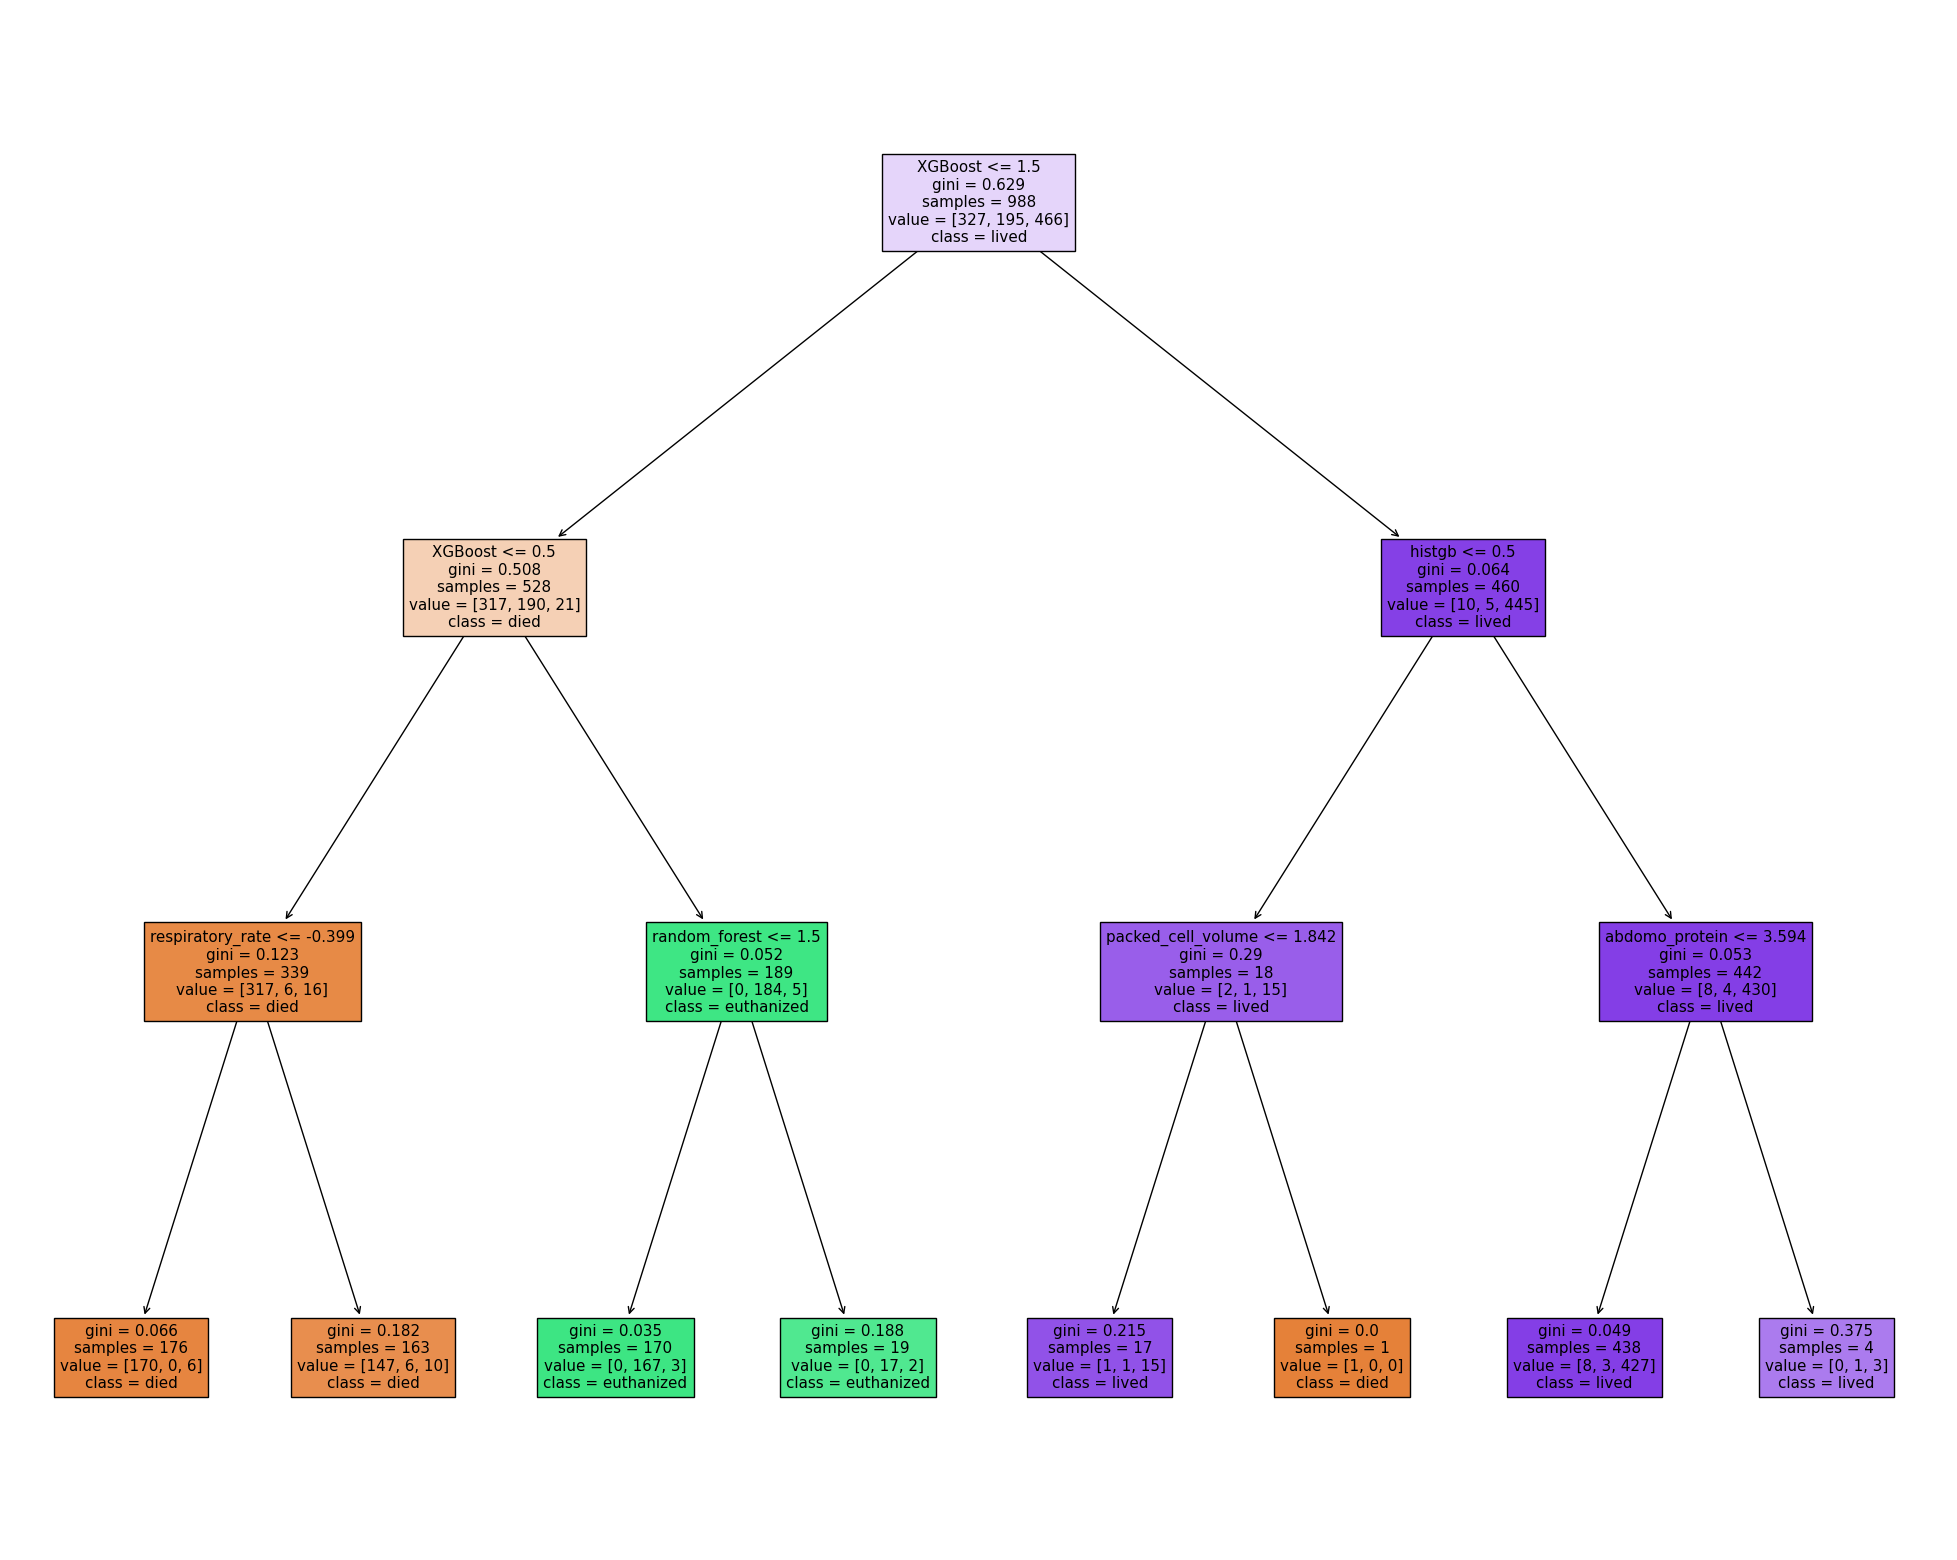

In [108]:
from sklearn import tree

FOLD_NO = 2
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree_classifiers_list[FOLD_NO], 
                   feature_names=list(train_preds_dfs_list[fold_no].columns),  
                   class_names=['died', 'euthanized', 'lived'],
                   filled=True)

In [109]:
FOLD_NO = 2
test_preds = decision_tree_classifiers_list[FOLD_NO].predict(X_test_with_preds_list[FOLD_NO])

In [110]:
PRED_CATEGORIES = ['died', 'euthanized', 'lived']
pred_list = [PRED_CATEGORIES[el] for el in test_preds]

submission_df = pd.DataFrame()
df_test_raw = pd.read_csv("data/test.csv")
submission_df['id'] = df_test_raw['id']
submission_df['outcome'] = pred_list

In [111]:
submission_df.to_csv("submissions/Without_Ordinal_Encoding/K_Fold_Cross_Val/DecisionTree_Ensemble_6_RandomForest_7_43_NearestCentroid_NaiveBayes_XGBoost_LGBM_HistGB_Submission.csv", index=False)